## CNN (convolutional neural network) Face Mask examples

Wei Li

In [1]:
import os
import torch
from torch import nn
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

import time
import random

# random_seed = 123
# os.environ["PL_GLOBAL_SEED"] = str(random_seed)
# random.seed(random_seed)
# np.random.seed(random_seed)

In [2]:
# %pip install watermark
%load_ext watermark
%watermark -a "Wei Li" -u -t -d -v -p numpy,torch,torchvision

Author: Wei Li

Last updated: 2023-12-28 10:37:16

Python implementation: CPython
Python version       : 3.8.17
IPython version      : 8.12.2

numpy      : 1.21.5
torch      : 1.12.1
torchvision: 0.13.1



In [3]:
# From local helper files
from utils_evaluation import set_all_seeds, set_deterministic, evaluate_epoch_loss, evaluate_epoch_metrics, get_predictions
from utils_plotting import plot_accuracy, plot_loss, show_images, plot_confusion_matrix

In [4]:
## Setting 
RANDOM_SEED = 2022
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
set_all_seeds(RANDOM_SEED)
set_deterministic()

### Data

https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset
The dataset consists of almost 12K images.
First download data from Kaggle. 

In [5]:
DATA_DIR = "/Users/wli169/Documents/Work/datasets/"
BATCH_SIZE = 32

test_path = DATA_DIR + "Face Mask Dataset/Test/"
train_path = DATA_DIR + "Face Mask Dataset/Train/"
val_path = DATA_DIR + "Face Mask Dataset/Validation/"

# transformCompose = transforms.Compose([transforms.ToTensor()])


transformCompose = transforms.Compose(
    [
        transforms.Resize((224, 224)),  # Image sizes may vary, resize to (224, 224).
        transforms.ToTensor(),  # change data from [0, 255] to [0.0, 1.0]
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
# The first list [0.485, 0.456, 0.406] is a set
# of means for each color channel (RGB), and the
# second list [0.229, 0.224, 0.225] is a set of standard deviations.


train_data = datasets.ImageFolder(train_path, transform=transformCompose)
test_data = datasets.ImageFolder(test_path, transform=transformCompose)
val_data = datasets.ImageFolder(val_path, transform=transformCompose)

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([32, 3, 224, 224])
Image label dimensions: torch.Size([32])
Class labels of 10 examples: tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 1])


In [7]:
print("Number of classes    : ", len(train_data.classes))
print("No. of train images  : ", train_data.__len__())
print("Shape of image       : ", train_data[0][0].shape)
print("No. of validation images  : ", val_data.__len__())
print("No. of test images  : ", test_data.__len__())
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", val_loader.__len__())
print("Test batches        : ", test_loader.__len__())

Number of classes    :  2
No. of train images  :  10000
Shape of image       :  torch.Size([3, 224, 224])
No. of validation images  :  800
No. of test images  :  992
Train batches        :  313
Val batches          :  25
Test batches        :  31


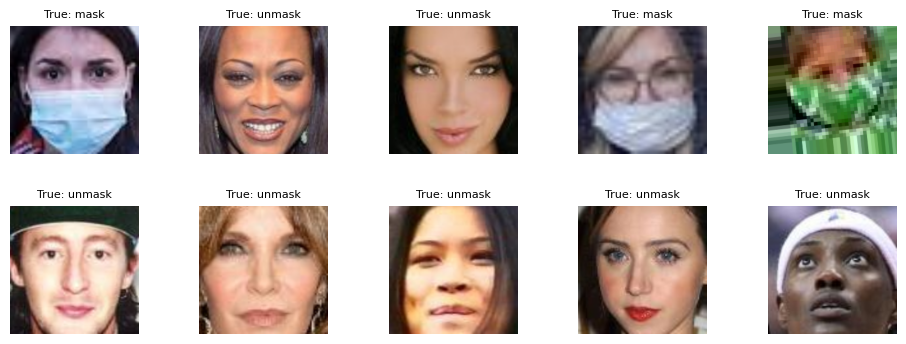

In [8]:
def extract_data_from_dataloader(dataloader, num_images=10):
    """
    Extract a specified number of images and labels from a DataLoader.

    Args:
        dataloader (DataLoader): The DataLoader to extract data from.
        num_images (int): Number of images to extract.

    Returns:
        Tuple of numpy arrays: (images, labels)
    """
    images, labels = next(iter(dataloader))
    return images[:num_images].numpy(), labels[:num_images].numpy()

train_images, train_labels = extract_data_from_dataloader(train_loader, num_images=10)

dict_label={0: "mask", 1: "unmask"}
show_images(train_images, train_labels, num_images=10, normalize=True, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), label_dict=dict_label)

Recall
\begin{align*}
\text { output size }=\frac{\text { input size }- \text { kernel size }+2 \times \text { padding }}{\text { stride }}+1
\end{align*}

### 1. Models (AlexNet)

In [9]:
class CustomAlexNet(torch.nn.Module):
# AlexNet
    def __init__(self, num_classes):
        super(CustomAlexNet, self).__init__()

        # Feature extractor part of the network
        self.features = torch.nn.Sequential(
            # First convolutional layer
            torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            # Input shape: (batch_size, 3, 224, 224)
            # Output shape: (batch_size, 64, 55, 55)
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            # Output shape: (batch_size, 64, 27, 27)

            # Second convolutional layer
            torch.nn.Conv2d(64, 192, kernel_size=5, padding=2),
            # Output shape: (batch_size, 192, 27, 27)
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            # Output shape: (batch_size, 192, 13, 13)

            # Third convolutional layer
            torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
            # Output shape: (batch_size, 384, 13, 13)
            torch.nn.ReLU(inplace=True),

            # Fourth convolutional layer
            torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
            # Output shape: (batch_size, 256, 13, 13)
            torch.nn.ReLU(inplace=True),

            # Fifth convolutional layer
            torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
            # Output shape: (batch_size, 256, 13, 13)
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            # Final output shape before adaptive pooling: (batch_size, 256, 6, 6)
        )
        
        # Adaptive pooling layer to ensure fixed size output
        self.avgpool = torch.nn.AdaptiveAvgPool2d((6, 6))
        # Output shape: (batch_size, 256, 6, 6)

        # Classifier part of the network
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256 * 6 * 6, 4096),  # Fully connected layer
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),  # Fully connected layer
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, num_classes)  # Output layer
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # Flatten the tensor for the linear layer
        logits = self.classifier(x)
        return logits



In [10]:
LR=0.01
NUM_EPOCHS=5

num_classes = 2  # As per your dataset
model = CustomAlexNet(num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)
# reduces the learning rate when a metric has stopped improving. 
# when the monitored quantity stops improving, the learning rate is multiplied by this factor
# 'max' so the learning rate will be reduced when the monitored metric has stopped increasing.


In [11]:
start_time = time.time()
(
    minibatch_loss_list,
    avg_loss_list,
    train_loss_list,
    val_loss_list,
    train_acc_list,
    val_acc_list,
) = ([], [], [], [], [], [])

for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(device)
        targets = targets.to(device)

        # ## FORWARD AND BACK PROP
        y_pred = model(features)
        loss = criterion(y_pred, targets)
        optimizer.zero_grad()

        loss.backward()

        # ## UPDATE MODEL PARAMETERS
        optimizer.step()

        step_len = float(optimizer.param_groups[0]["lr"])

        # ## LOGGING
        minibatch_loss_list.append(loss.item())
        if not batch_idx % 50:
            print(
                f"Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} "
                f"| Batch {batch_idx:04d}/{len(train_loader):04d} "
                f"| Loss: {loss:.4f}"
                f"| Step len: {step_len:.6f}"
            )

    model.eval()
    with torch.no_grad():  # save memory during inference
        ### logging for running average of loss over all traversed minibatches
        # avg_loss = torch.mean(torch.FloatTensor(minibatch_loss_list))
        # or the average over most recent minibatches in last epoch
        avg_loss = torch.mean(
            torch.FloatTensor(minibatch_loss_list[-len(train_loader) :])
        )
        avg_loss_list.append(avg_loss)

        train_loss = evaluate_epoch_loss(
            model, train_loader, device=device, criterion=nn.CrossEntropyLoss()
        )[1]
        val_loss = evaluate_epoch_loss(
            model, val_loader, device=device, criterion=nn.CrossEntropyLoss()
        )[1]

        train_acc = evaluate_epoch_metrics(model, train_loader, device=device)
        val_acc = evaluate_epoch_metrics(model, val_loader, device=device)

        # Print train and test loss along with accuracy
        print(
            f"Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} "
            f"| Train Loss: {train_loss:.4f} "
            f"| Valid Loss: {val_loss:.4f} "
            f"| Train Acc: {train_acc:.2f}% "
            f"| Valid Acc: {val_acc:.2f}% "
        )

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

    if scheduler is not None:
        # adjust step length based on the following metric
        scheduler.step(val_acc_list[-1])
        # scheduler.step(avg_loss_list[-1]) for mode='min'

    elapsed = (time.time() - start_time) / 60
    print(f"Time elapsed: {elapsed:.2f} min")

elapsed = (time.time() - start_time) / 60
print(f"Total Training Time: {elapsed:.2f} min")

print()
test_acc = evaluate_epoch_metrics(model, test_loader, device=device)
print(f"Test accuracy {test_acc :.2f}")

# benchmark:
# Epoch: 005/005 | Train Loss: 0.0189 | Valid Loss: 0.0345 | Train Acc: 99.30% | Valid Acc: 98.62%
# Test accuracy 98.59

Epoch: 001/005 | Batch 0000/0313 | Loss: 0.6935| Step len: 0.010000
Epoch: 001/005 | Batch 0050/0313 | Loss: 0.7140| Step len: 0.010000
Epoch: 001/005 | Batch 0100/0313 | Loss: 0.1774| Step len: 0.010000
Epoch: 001/005 | Batch 0150/0313 | Loss: 0.3315| Step len: 0.010000
Epoch: 001/005 | Batch 0200/0313 | Loss: 0.1735| Step len: 0.010000
Epoch: 001/005 | Batch 0250/0313 | Loss: 0.2876| Step len: 0.010000
Epoch: 001/005 | Batch 0300/0313 | Loss: 0.1221| Step len: 0.010000
Epoch: 001/005 | Train Loss: 0.1703 | Valid Loss: 0.1710 | Train Acc: 94.66% | Valid Acc: 94.38% 
Time elapsed: 6.41 min
Epoch: 002/005 | Batch 0000/0313 | Loss: 0.1189| Step len: 0.010000
Epoch: 002/005 | Batch 0050/0313 | Loss: 0.1282| Step len: 0.010000
Epoch: 002/005 | Batch 0100/0313 | Loss: 0.1938| Step len: 0.010000
Epoch: 002/005 | Batch 0150/0313 | Loss: 0.1199| Step len: 0.010000
Epoch: 002/005 | Batch 0200/0313 | Loss: 0.1303| Step len: 0.010000
Epoch: 002/005 | Batch 0250/0313 | Loss: 0.2225| Step len: 0.01

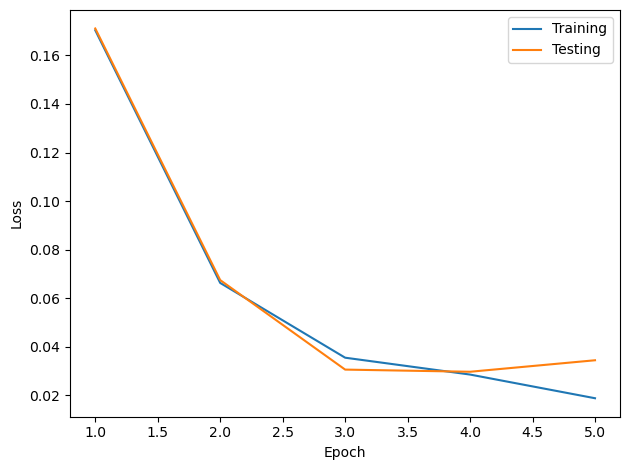

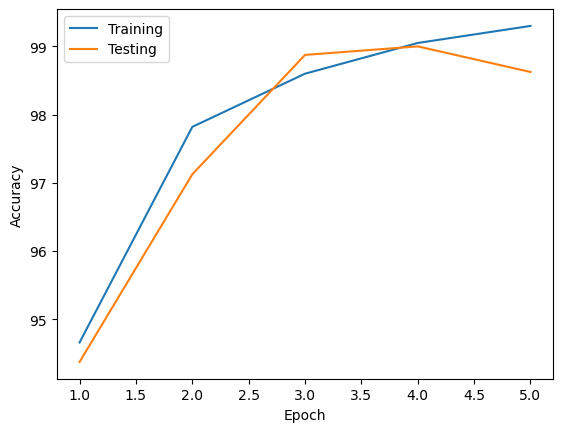

In [12]:
# Evaluation
plot_loss(train_loss_list=train_loss_list,
              valid_loss_list=val_loss_list,
              results_dir=None)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=val_acc_list,
              results_dir=None)
plt.show()

### 2. Models (ResNet)

- The residual learning approach reformulates the mapping learned by a few stacked layers as $F(x):=H(x)-x$, where $H(x)$ is the desired underlying mapping and $F(x)$ is the residual mapping. The original mapping is then recast into $F(x)+x$.
- This is implemented using shortcut connections that perform identity mapping, with their outputs being added to the outputs of the stacked layers. The operation can be expressed as $y=F\left(x,\left\{W_i\right\}\right)+x$, where $x$ and $y$ are the input and output vectors of the layers considered, and $F\left(x,\left\{W_i\right\}\right)$ represents the residual mapping to be learned.

<img src="./images/cnn_res1.png" width="300" height="230">

In [13]:
class BasicBlock(nn.Module):
    """
    Basic building block for ResNet with two convolutional layers and a skip connection.

    Args:
        in_channels (int): Number of channels in the input.
        out_channels (int): Number of channels produced by the convolution.
        stride (int, optional): Stride of the FIRST convolution layer. Default: 1
        projection (nn.Module, optional): projection layer if the input and output dimensions differ.
            For these skip connections to work properly, the input and output of the block must have
            the same shape (spatial dims + channels).
            The projection layer is used to modify the block's input so that it matches the shape of
            the output.
            Typically, projection is a small neural network itself.

    Shape change in self.conv1:
        - Kernel size of 3 with padding of 1 keeps the spatial dimensions (height and width) same if stride is 1.
        - If stride is greater than 1 (typically 2), it will reduce the spatial dimensions by half. For example:
        If input shape is (batch_size, in_channels, H, W), the output shape will be:
        (batch_size, out_channels, H/stride, W/stride)

    Shape change in self.conv2:
        - This layer maintains the number of channels and does not change the spatial dimensions.
        - Since stride is 1 and padding is 1 for a kernel size of 3, the output spatial dimensions remain unchanged.
    """

    def __init__(self, in_channels, out_channels, stride=1, projection=None):
        super(BasicBlock, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Second convolutional layer
        # not changing spatial dims, or channels depths
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.projection = projection
        self.stride = stride

    def forward(self, x):
        identity = x

        # Forward pass through the first layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Forward pass through the second layer
        out = self.conv2(out)
        out = self.bn2(out)

        # Apply projection if it is defined
        if self.projection is not None:
            identity = self.projection(x)

        # Adding the shortcut (identity)
        out += identity
        out = self.relu(out)

        return out

In [14]:
class ResNet(nn.Module):
    """
    Simplified ResNet model with configurable layers and blocks.

    Args:
        block (nn.Module): Type of block to use (BasicBlock).
        num_blocks (list): Number of blocks in each layer.
        num_classes (int): Number of output classes.
    """

    def __init__(self, block, num_blocks, num_classes=2):
        super(ResNet, self).__init__()
        self.in_channels = 64

        # Initial convolutional layer
        # Input shape: (batch_size, 3, 224, 224) for standard RGB images
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Output shape: (batch_size, 64, 112, 112)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # Output shape after maxpool: (batch_size, 64, 56, 56)

        # ResNet layers
        # Each layer consists of 'block' repeated 'num_blocks[i]' times
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        # Output shape: (batch_size, 64, 56, 56) - spatial dimensions unchanged in layer1
        # All remaining layers are doubling of channels and halving of spatial dimensions at each new layer
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        # Output shape: (batch_size, 128, 28, 28)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        # Output shape: (batch_size, 256, 14, 14)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # Output shape: (batch_size, 512, 7, 7)

        # Adaptive pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # Output shape after avgpool: (batch_size, 512, 1, 1)
        self.fc = nn.Linear(512, num_classes)
        # Output shape: (batch_size, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        """
        Creates a layer with specified (multiple) blocks for ResNet.

        Args:
            block (nn.Module): The block type to use (BasicBlock or Bottleneck).
            out_channels (int): Number of output channels for this layer.
            blocks (int): Number of blocks to be added in this layer.
            stride (int): Stride size for the first block of the layer.

        Returns:
            nn.Sequential: A layer consisting of 'blocks' number of 'block'.

        The first block of each layer may have a stride greater than 1 or a
        different number of output channels than the input channels. In such cases,
        a projection convolutional layer is added to adjust the size of the skip
        connection to match the output of the block.

        The subsequent blocks in each layer use a stride of 1 and do not change the
        spatial dimensions or channel depth further.

        Example:
            Creating layer2 in ResNet with 2 BasicBlocks, each having 128 output channels.
            layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
            The first block uses stride=2 and projection to match input and output dimensions.
        """

        projection = None
        # Check if we need to adjust the dimensions of the input to match the output
        if stride != 1 or self.in_channels != out_channels:
            projection = nn.Sequential(
                # 1x1 Convolution to adjust channel dimensions and stride
                nn.Conv2d(
                    self.in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels),
            )
            # This convolution changes the number of channels and spatial dimensions
            # If stride > 1, it also reduces spatial dimensions (height and width)
            # this projection is applied to input to match the shape of output.

        layers = []
        # First block in the layer, might have projection
        layers.append(block(self.in_channels, out_channels, stride, projection))

        self.in_channels = out_channels
        # For subsequent blocks in the layer, stride is 1 and there's no projection
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
            # These blocks do not alter the spatial dimensions or channel depth

        return nn.Sequential(*layers)

    def forward(self, x):
        # Pass through the initial layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Pass through ResNet layers
        # Except the first layer, with each new layer, the number of channels is doubled,
        # and the height and width are halved.
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Adaptive pooling and output layer
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

Example ResNet18: `layers=[2, 2, 2, 2]`

- The [2, 2, 2, 2] list means there are 4 sets of blocks, each set containing 2 BasicBlock instances.
- Each BasicBlock has 2 convolutional layers.
- Thus, in total, there are 2 * 2 = 4 layers per set.

Since there are 4 such sets, the total number of layers in all blocks is 4 sets * 4 layers/set = 16 layers.

Total Number of Layers:

Adding them up: 1 (initial conv) + 16 (residual blocks layes) + 1 (fully connected) = 18 layers.

In [15]:
LR = 0.01
NUM_EPOCHS = 5

num_classes = 2  # As per your dataset

model2 = ResNet(
    BasicBlock, [2, 2, 2, 2], num_classes=num_classes
)  # Example: ResNet18-like architecture
model2 = model2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer2 = torch.optim.SGD(model2.parameters(), momentum=0.8, lr=LR)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer2, factor=0.1, mode="min", verbose=True
)
# reduces the learning rate when a metric has stopped improving.
# when the monitored quantity stops improving, the learning rate is multiplied by this factor
# 'min' so the learning rate will be reduced when the monitored metric has stopped decreasing.

In [16]:
start_time = time.time()

(
    minibatch_loss_list,
    avg_loss_list,
    train_loss_list,
    val_loss_list,
    train_acc_list,
    val_acc_list,
) = ([], [], [], [], [], [])

for epoch in range(NUM_EPOCHS):
    model2.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(device)
        targets = targets.to(device)

        # ## FORWARD AND BACK PROP
        y_pred = model2(features)
        loss = criterion(y_pred, targets)
        optimizer2.zero_grad()

        loss.backward()

        # ## UPDATE MODEL PARAMETERS
        optimizer2.step()

        step_len = float(optimizer2.param_groups[0]["lr"])

        # ## LOGGING
        minibatch_loss_list.append(loss.item())
        if not batch_idx % 50:
            print(
                f"Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} "
                f"| Batch {batch_idx:04d}/{len(train_loader):04d} "
                f"| Loss: {loss:.4f}"
                f"| Step len: {step_len:.6f}"
            )

    model2.eval()
    with torch.no_grad():  # save memory during inference
        ### logging for running average of loss over all traversed minibatches
        # avg_loss = torch.mean(torch.FloatTensor(minibatch_loss_list))
        # or the average over most recent minibatches in last epoch
        avg_loss = torch.mean(
            torch.FloatTensor(minibatch_loss_list[-len(train_loader) :])
        )
        avg_loss_list.append(avg_loss)

        train_loss = evaluate_epoch_loss(
            model2, train_loader, device=device, criterion=nn.CrossEntropyLoss()
        )[1]
        val_loss = evaluate_epoch_loss(
            model2, val_loader, device=device, criterion=nn.CrossEntropyLoss()
        )[1]

        train_acc = evaluate_epoch_metrics(model2, train_loader, device=device)
        val_acc = evaluate_epoch_metrics(model2, val_loader, device=device)

        # Print train and test loss along with accuracy
        print(
            f"Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} "
            f"| Train Loss: {train_loss:.4f} "
            f"| Valid Loss: {val_loss:.4f} "
            f"| Train Acc: {train_acc:.2f}% "
            f"| Valid Acc: {val_acc:.2f}% "
        )

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

    if scheduler2 is not None:
        # adjust step length based on the following metric
        # scheduler2.step(val_acc_list[-1])
        scheduler2.step(avg_loss_list[-1]) 

    elapsed = (time.time() - start_time) / 60
    print(f"Time elapsed: {elapsed:.2f} min")

elapsed = (time.time() - start_time) / 60
print(f"Total Training Time: {elapsed:.2f} min")

print()
test_acc = evaluate_epoch_metrics(model2, test_loader, device=device)
print(f"Test accuracy {test_acc :.2f}")

# benchmark:


Epoch: 001/005 | Batch 0000/0313 | Loss: 0.9674| Step len: 0.010000
Epoch: 001/005 | Batch 0050/0313 | Loss: 0.1137| Step len: 0.010000
Epoch: 001/005 | Batch 0100/0313 | Loss: 0.2109| Step len: 0.010000
Epoch: 001/005 | Batch 0150/0313 | Loss: 0.1106| Step len: 0.010000
Epoch: 001/005 | Batch 0200/0313 | Loss: 0.2894| Step len: 0.010000
Epoch: 001/005 | Batch 0250/0313 | Loss: 0.0198| Step len: 0.010000
Epoch: 001/005 | Batch 0300/0313 | Loss: 0.0417| Step len: 0.010000
Epoch: 001/005 | Train Loss: 0.1174 | Valid Loss: 0.1442 | Train Acc: 96.88% | Valid Acc: 96.62% 
Time elapsed: 21.32 min
Epoch: 002/005 | Batch 0000/0313 | Loss: 0.1930| Step len: 0.010000
Epoch: 002/005 | Batch 0050/0313 | Loss: 0.0862| Step len: 0.010000
Epoch: 002/005 | Batch 0100/0313 | Loss: 0.0247| Step len: 0.010000
Epoch: 002/005 | Batch 0150/0313 | Loss: 0.0141| Step len: 0.010000
Epoch: 002/005 | Batch 0200/0313 | Loss: 0.0180| Step len: 0.010000
Epoch: 002/005 | Batch 0250/0313 | Loss: 0.2329| Step len: 0.0

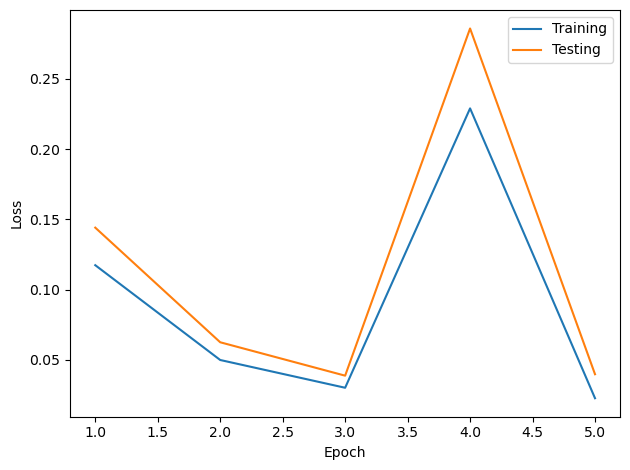

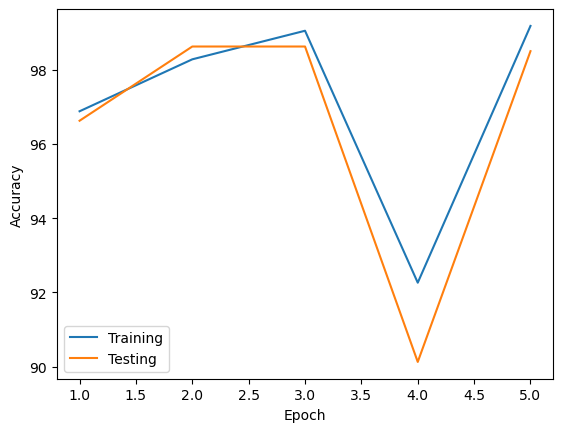

In [17]:
# Evaluation
plot_loss(
    train_loss_list=train_loss_list, valid_loss_list=val_loss_list, results_dir=None
)
plt.show()

plot_accuracy(
    train_acc_list=train_acc_list, valid_acc_list=val_acc_list, results_dir=None
)
plt.show()

#### Predictions

In [18]:
# Get predictions
test_images, test_labels, test_predictions = get_predictions(model, test_loader, device)

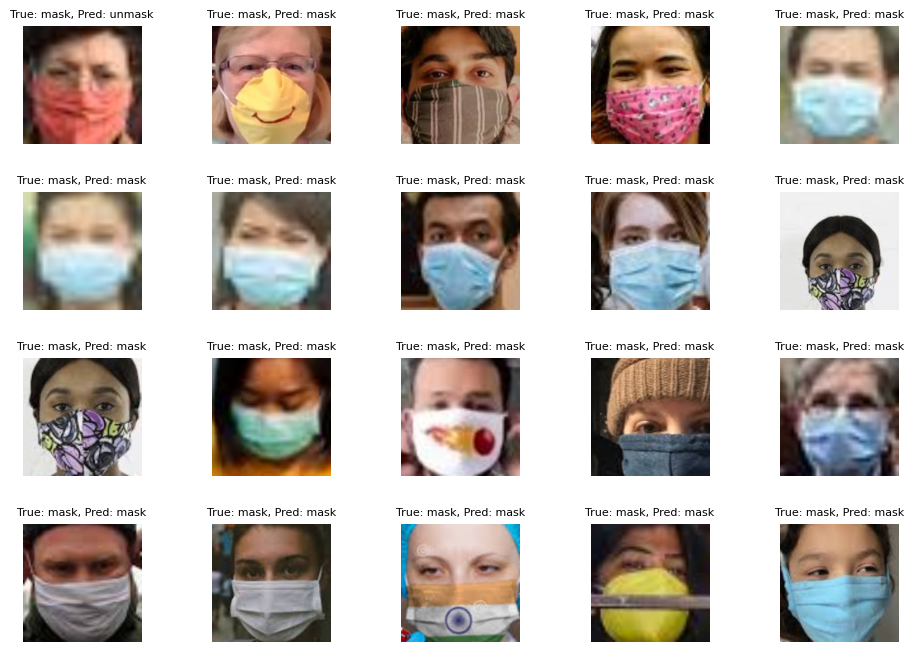

In [19]:
# Visualize the first 10 test images with predictions
show_images(
    test_images,
    test_labels,
    test_predictions,
    num_images=20,
    normalize=True,
    mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225),
    label_dict=dict_label,
)

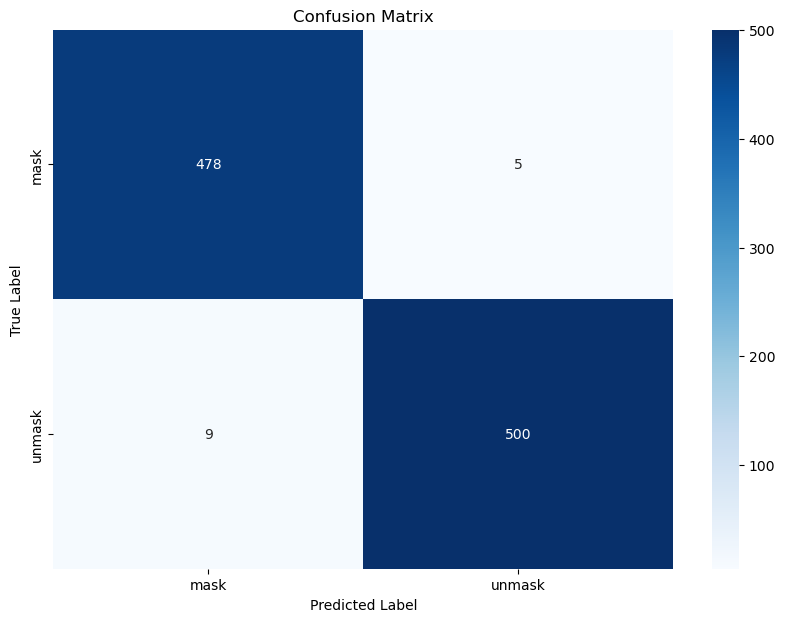

In [20]:
plot_confusion_matrix(test_labels, test_predictions, dict_label)

In [21]:
# check those with wrong predictions

mismatched_images = []
mismatched_labels = []
mismatched_predictions = []

for img, label, prediction in zip(test_images, test_labels, test_predictions):
    if label != prediction:
        mismatched_images.append(img)
        mismatched_labels.append(label)
        mismatched_predictions.append(prediction)

len(mismatched_labels), len(mismatched_predictions)

(14, 14)

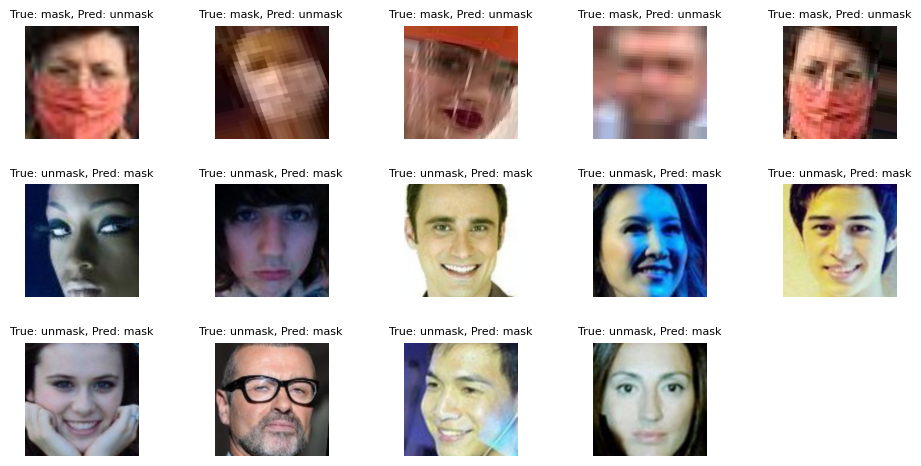

In [22]:
# Visualize the test images that got wrong predictions
show_images(
    mismatched_images,
    mismatched_labels,
    mismatched_predictions,
    num_images=50,
    normalize=True,
    mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225),
    label_dict=dict_label,
)